# The first step is preprocessing. We use the [SSBD Dataset](https://rolandgoecke.net/research/datasets/ssbd/) in order to get the data for hand flapping and spinning. 

## The dataset does contain 75 URLs (although we'll ignore all headbanging videos) to youtube videos. All the data is nicely stored in XML files that I will read to get the youtube videos and also the time stamps of when the behavior (hand flapping or spinning) occurs. Then I will use pytube to download the youtube videos to .mp4 and moviepy to cut the .mp4 videos into the areas of interest. Finally, because some of those areas of interest clips are more than a few seconds long (which is all you need to detect spinning or headbanging) I will take those areas that are > 8 seconds and split them into many clips (that way we have more data.) Also in sections of the video where no behavior is used I will take them as videos as control data. 

In [1]:
# first change the directory over to ssbd release
import os 
import xml.etree.ElementTree as ET

In [2]:
# next step would be to get the hand flapping and spinning data 

tree = ET.parse("ssbd-release/Annotations/v_ArmFlapping_07.xml")
root = tree.getroot()
for child in root:
    # for each child in the root 
    if child.tag == "url":
        print(child.text)
    if child.tag == "behaviours":
        for behavior in child: # go through each reported behavior 
            for tag in behavior: # tag is just the attribute of the behavior 
                if tag.tag == "time":
                    print(tag.text)
                if tag.tag == "intensity":
                    print(tag.text)
                if tag.tag == "category":
                    print(tag.text)

http://www.youtube.com/watch?v=T9rbit_oiJA
0004:0010
armflapping
high
0015:0020
armflapping
high


In [3]:
def convert_to_second(time : str) -> int:
    # this will take in a time like "0125" or 1:25 and make it 85 (60 + 25)
    overall_seconds = 0 
    for i, time_char in enumerate(reversed(time)):
        if i == 0:
            overall_seconds += int(time_char)
        if i == 1:
            overall_seconds += int(time_char) * 10
        if i == 2:
            overall_seconds += int(time_char) * 60 
        if i == 3:
            overall_seconds += int(time_char) * 600 
    return overall_seconds 

assert convert_to_second('2345') == 23 * 60 + 45  

def consecutive(data, stepsize=1):
    '''groups up elements in an array that are continous with each other (useful to create sections where none 
    of the behaviors are shown.)'''
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [4]:
from collections import defaultdict
import math 
import numpy as np

NUM_SECONDS_TO_RECOGNIZE = 8 # hypothesis: takes this many seconds seconds to recognize handflapping + spinning 

URLS_TO_DOWNLOAD = set() # contains all youtube videos to download 
links_to_times = {} # data will be stored here like {link : {'category' : [(start, end)], 'another cat' : [(start, end)]}


for i, file_name in enumerate(os.listdir('ssbd-release/Annotations/')):
    # parse this file 
    tree = ET.parse('ssbd-release/Annotations/' + file_name)
    root = tree.getroot() 
    
    # everything we need to store
    URL = ""
    
    for child in root:
        
        if child.tag == "url":
            URL = child.text # store URL
            URLS_TO_DOWNLOAD.add(URL)
            links_to_times[URL] = defaultdict(list) 
        
        if child.tag == "duration":
            duration = int(child.text[:-1])
            all_times = list(range(duration))
        
        if child.tag == "behaviours": # this child has the list of behaviors 
            for reported_behavior in child: 
                for info in reported_behavior:
                    # gather the start time, end time, and category for this youtube link 
                    if info.tag == "time":
                        # the time will be start:end 
                        times = str(info.text) # contains the string 
                        if times.count(":"): 
                            divider_index = times.index(":")
                        elif times.count("-"):
                            divider_index = times.index("-")
                        else:
                            break # invalid then 
                        actual_start_time, actual_end_time = convert_to_second(times[:divider_index]), convert_to_second(times[divider_index + 1:])
                        START_TIMES, END_TIMES = [], []
                        times = np.array(range(actual_start_time, actual_end_time +1))
                        for time in times:
                            try:
                                all_times.remove(time)
                            except Exception as e:
                                pass 
                        split_times = np.array_split(times, math.ceil(times.shape[0] / NUM_SECONDS_TO_RECOGNIZE))
                        for time in split_times:
                            START_TIMES.append(time[0])
                            END_TIMES.append(time[-1])
                    if info.tag == "category":
                        # this is the label 
                        LABEL = info.text 
                
                # create an entry for this reported behavior 
                for START_TIME, END_TIME in zip(START_TIMES, END_TIMES):
                    links_to_times[URL][LABEL].append((START_TIME, END_TIME))
                    
            idle_times = consecutive(np.array(all_times))
            num_contributed = 0 # each video can only give 4 control clips (because otherwise it takes WAY too long)
            for control_times in idle_times:
                if num_contributed >= 4: 
                    break 
                # times maybe > NUM_SECONDS_TO_RECOGNIZE so split if that is the case 
                if len(control_times) <= NUM_SECONDS_TO_RECOGNIZE:
                    START_TIME, END_TIME = control_times[0], control_times[-1]
                    links_to_times[URL]['control'].append((START_TIME, END_TIME))
                    num_contributed += 1
                else:
                    # needs to be split 
                    control_times_split = np.array_split(control_times, math.ceil(len(control_times) / NUM_SECONDS_TO_RECOGNIZE))
                    for control_time in control_times_split:  
                        START_TIME, END_TIME = control_time[0], control_time[-1]
                        links_to_times[URL]['control'].append((START_TIME, END_TIME))
                        num_contributed += 1
                        if num_contributed >= 4: 
                            break 

In [5]:
links_to_times

{'http://www.youtube.com/watch?v=Pqd9Vu-juPI': defaultdict(list,
             {'spinning': [(10, 15)],
              'control': [(0, 4), (5, 9), (16, 23), (24, 31)]}),
 'http://www.youtube.com/watch?v=yMgx2lVjf5I': defaultdict(list,
             {'headbanging': [(1, 7), (18, 25), (36, 43), (44, 50)],
              'control': [(0, 0), (8, 12), (13, 17), (26, 30)]}),
 'http://www.youtube.com/watch?v=WRGUUOZ5_wA': defaultdict(list,
             {'armflapping': [(60, 67), (60, 67)],
              'control': [(0, 7), (8, 15), (16, 23), (24, 31)]}),
 'http://www.youtube.com/watch?v=8vFUIFEfRpA': defaultdict(list,
             {'armflapping': [(2, 8), (9, 14)],
              'control': [(0, 1), (15, 21), (22, 28), (29, 34)]}),
 'http://www.youtube.com/watch?v=SOc13pnf-Dc': defaultdict(list,
             {'armflapping': [(65, 71),
               (72, 78),
               (79, 85),
               (132, 136),
               (137, 140)],
              'control': [(0, 7), (8, 15), (16, 22), (23, 29

In [6]:
# pickle this just incase 
import pickle 
with open("links_to_times.pkl", 'wb') as f:
    pickle.dump(links_to_times, f)

In [ ]:
import cv2
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
import pytube
FPS = 30 
i = 0 
for vid, (url, category_times) in enumerate((links_to_times.items())): 
    print(f"staring the {vid+1}th file")
    # download the video 
    print(url)
    try: 
        print("This is url: ", url)
        y = pytube.YouTube(url)
        video = y.streams.get_highest_resolution()
        video.download()
    except Exception as e:
        print(f"annoying url: {url}")
        print(e)
        continue 
        
    for category, times in category_times.items(): 
        folder_path = "behavior_data/" + category + "/"
        
        for start_time, end_time in times:
            try:
                input_file = y.streams.get_highest_resolution().default_filename
                output_file = folder_path + f"{i}.mp4"
                print(os.listdir(folder_path))
                if f"{i}.mp4" not in os.listdir(folder_path):
                    print("adding file")
                    with VideoFileClip(input_file) as video:
                        new = video.subclip(start_time, end_time)
                        new.write_videofile(output_file, audio_codec='aac')
                        i += 1 
            except Exception as e:
                print(f"failed on {i}")
                i += 1 
    os.remove(y.streams.get_highest_resolution().default_filename)

# Directory Structure  

## We have one folder inside of this AnishMachineLearning folder called "behavior_data" that has the "armflapping" and "spinning" folders. There all of the sliced .mp4 files with the behavior of interest are located. 

### We will process headbanging videos even if we are not going to use it because we still want it as a negative case for training the arm flapping & spinning. 

In [ ]:
# for spinning it is just the hand positions that matter right?

import cv2
import mediapipe as mp 
import numpy as np
mp_hands = mp.solutions.hands


cap = cv2.VideoCapture("/Users/anish/Documents/Machine Learning Env/AnishMachineLearning/behavior_data/spinning/37.mp4")
#cap = cv2.VideoCapture(0)
# Initiate holistic model

#capcv2.VideoCapture(0)

hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

while cap.isOpened():
    ret, image = cap.read() 
    if not ret:break 

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    height, width, _ = image.shape

    white_image = np.zeros_like(image)
    white_image.fill(255.0)
    
    #check for hand results 
    if results.multi_hand_landmarks:
        for hand_landmark in results.multi_hand_landmarks:
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                x = int(landmark.x * width)
                y = int(landmark.y * height)
                cv2.circle(white_image, (x, y), 5, (100, 100, 0), -1)

    cv2.imshow("", white_image)

    if cv2.waitKey(1) == ord("q"):
        break 

cap.release() 
cv2.destroyAllWindows()

In [ ]:
list(range(21))

# We can try using the y values for each of the hand flapping videos and graph them to see if there is a noticeable difference of the y-values (we'll use the mean of all y-values for all 21 hand landmarks and then graph them).

In [ ]:
import matplotlib.pyplot as plt
import os , cv2
import mediapipe as mp

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/armflapping"):
    video = "behavior_data/armflapping/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

In [ ]:
# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/spinning"):
    video = "behavior_data/spinning/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

In [ ]:
# next for headbanging 

# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/headbanging"):
    video = "behavior_data/headbanging/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

# First let's get the frames for every arm flapping and control video. If the number of frames is less than 100 frames we will not take it. 

In [2]:
from PIL import Image as im 
import mediapipe as mp
def hand_locations(frame, min_detection_confidence = 0.2, min_tracking_confidence = 0.2): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [2] * 42
    Y_locations = [2] * 42 
    Z_locations = [2] * 42
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[i * (hand + 1)] = landmark.x
                Y_locations[i * (hand + 1)] = landmark.y
                Z_locations[i * (hand + 1)] = landmark.z
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
import os, cv2
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []

NUM_KEEP = 100

for video_name in os.listdir('behavior_data/armflapping'): 
    cap = cv2.VideoCapture('behavior_data/armflapping/' + video_name)  
    FRAMES = [] # frames for this video 
    while True: 
        _, image = cap.read() 
        if not _ : break 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        locs = hand_locations(image)
        

        FRAMES.append(locs)
    if len(FRAMES) >= NUM_KEEP and np.sum(np.array(FRAMES)) > 0: 
        # ignore any .DS_Store files
        ARMFLAPPING_VIDEOS.append(np.array(FRAMES))
    
    print("on a new video!")

ARMFLAPPING_LABELS = np.ones(len(ARMFLAPPING_VIDEOS))

for video_name in os.listdir('behavior_data/control'): 
    cap = cv2.VideoCapture('behavior_data/control/' + video_name)  
    FRAMES = [] # frames for this video 
    while True: 
        _, image = cap.read() 
        if not _ : break 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        locs = hand_locations(image)
                    
        FRAMES.append(locs)
        
    if len(FRAMES) >= NUM_KEEP and np.sum(np.array(FRAMES)) > 0: 
        CONTROL_VIDEOS.append(np.array(FRAMES))
    
    print("continuing on")

CONTROL_LABELS = np.zeros(len(CONTROL_VIDEOS))

on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new video!
on a new

In [7]:
#### shuffle and then balance the amount of videos
print(len(CONTROL_VIDEOS), len(ARMFLAPPING_VIDEOS))
amount_of_videos = min([len(CONTROL_VIDEOS), len(ARMFLAPPING_VIDEOS)])

ARMFLAPPING_VIDEOS = np.array(ARMFLAPPING_VIDEOS, dtype = "object")
CONTROL_VIDEOS = np.array(CONTROL_VIDEOS, dtype = "object")
import numpy as np
control_permutation = np.random.permutation(CONTROL_LABELS.shape[0])
CONTROL_VIDEOS, CONTROL_LABELS = CONTROL_VIDEOS[control_permutation], CONTROL_LABELS[control_permutation]

armflapping_permutation = np.random.permutation(ARMFLAPPING_LABELS.shape[0])
ARMFLAPPING_VIDEOS, ARMFLAPPING_LABELS = ARMFLAPPING_VIDEOS[armflapping_permutation], ARMFLAPPING_LABELS[armflapping_permutation]

ARMFLAPPING_VIDEOS, ARMFLAPPING_LABELS = ARMFLAPPING_VIDEOS[:amount_of_videos], ARMFLAPPING_LABELS[:amount_of_videos]
CONTROL_VIDEOS, CONTROL_LABELS = CONTROL_VIDEOS[:amount_of_videos], CONTROL_LABELS[:amount_of_videos]

46 60


In [ ]:
assert len(ARMFLAPPING_VIDEOS) == len(CONTROL_VIDEOS)

In [8]:
selected_armflapping_frames = [] # the dimensions of this will be (BS, 100, 84) 
selected_control_frames = [] 

for FRAMES in ARMFLAPPING_VIDEOS: 
    selected_armflapping_frames.append(FRAMES[:NUM_KEEP])

for FRAMES in CONTROL_VIDEOS: 
    selected_control_frames.append(FRAMES[:NUM_KEEP])

In [9]:
ARMFLAPPING_LOCATIONS = np.array(selected_armflapping_frames)
CONTROL_LOCATIONS = np.array(selected_control_frames)

In [10]:
# save these in a pickle file

import pickle 
with open("armflapping_locations.pickle", 'wb') as f: 
    pickle.dump(ARMFLAPPING_LOCATIONS, f)

with open('control_locations.pickle', 'wb') as f: 
    pickle.dump(CONTROL_LOCATIONS, f)

In [11]:
# load them back in 
import numpy as np
from numpy import ndarray 
import pickle 

with open("armflapping_locations.pickle", 'rb') as f: 
    ARMFLAPPING_LOCATIONS = pickle.load(f)

with open('control_locations.pickle', 'rb') as f: 
    CONTROL_LOCATIONS = pickle.load(f)

# Now that we have the data for both classes, we'll concatenate it and start training (first with no augmentations.) 

In [93]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS, random_state = 42): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = random_state)
    
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS)

In [94]:
# start training with a vanilla LSTM. 
import tensorflow as tf
tf.config.run_functions_eagerly(True)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences = True), 
    tf.keras.layers.LSTM(128, return_sequences = True), 
    tf.keras.layers.LSTM(256, return_sequences = False), 
    tf.keras.layers.Dense(128, activation = "relu"), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

In [95]:
history = model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))

Epoch 1/200
3/3 [==============================] - 2s 753ms/step - loss: 0.6861 - accuracy: 0.4783 - val_loss: 0.6260 - val_accuracy: 0.6087
Epoch 2/200
3/3 [==============================] - 2s 547ms/step - loss: 0.6771 - accuracy: 0.5362 - val_loss: 0.5390 - val_accuracy: 0.8261
Epoch 3/200
3/3 [==============================] - 2s 549ms/step - loss: 0.5723 - accuracy: 0.7681 - val_loss: 0.4098 - val_accuracy: 0.8696
Epoch 4/200
3/3 [==============================] - 2s 579ms/step - loss: 0.4965 - accuracy: 0.7826 - val_loss: 0.4611 - val_accuracy: 0.8261
Epoch 5/200
3/3 [==============================] - 2s 585ms/step - loss: 0.5895 - accuracy: 0.6667 - val_loss: 0.4262 - val_accuracy: 0.8696
Epoch 6/200
3/3 [==============================] - 2s 604ms/step - loss: 0.5042 - accuracy: 0.7536 - val_loss: 0.4340 - val_accuracy: 0.8261
Epoch 7/200
3/3 [==============================] - 2s 604ms/step - loss: 0.5377 - accuracy: 0.7536 - val_loss: 0.4135 - val_accuracy: 0.8261
Epoch 8/200
E

## We can also plot our results for a visualization of overfitting. 

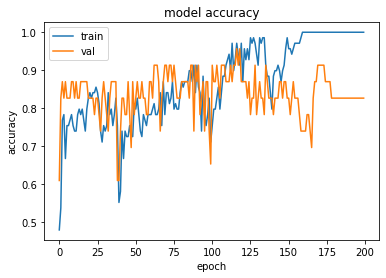

In [96]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot(history)

# Time to do add image augmentations!

## Our model could also be struggling a bit because of: 

- not enough data (image augmentations can help) 
- too short data (meaning 100 frames isn't enough to detect) 
    - just make it second dependent 
- bad data (camera shaky / hands not seen in video) 

# First we will try solving the issue with the geometric augmentations. 

In [81]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)

In [87]:
import random 

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X 
        
class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = None):
        if training: 
            return tf.map_fn(_shift, X)
        else: 
            return None 

## We'll probably want to first check to see if our image augmentations make sense. 

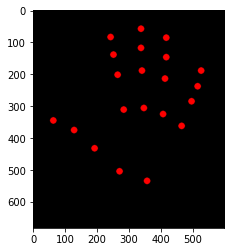

In [72]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("hands.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
locations = hand_locations(image) 

def draw_on_image(image, locations): 
    X_locations, Y_locations = locations[:42], locations[42:84]
    height, width, _ = image.shape

    new_image = np.zeros_like(image)
    for loc_x, loc_y in zip(X_locations, Y_locations): 
        if loc_x == 2 or loc_y == 2: continue 
        x = int(width * loc_x)
        y = int(height * loc_y)
        new_image = cv2.circle(new_image, (x, y), 5, (255, 0, 0), 10)
    plt.imshow(new_image)
    plt.show()

draw_on_image(image, locations)

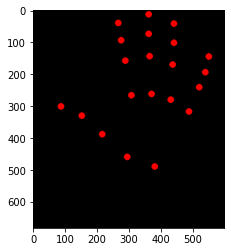

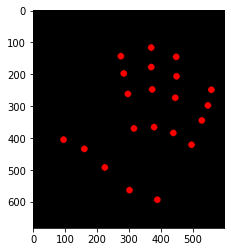

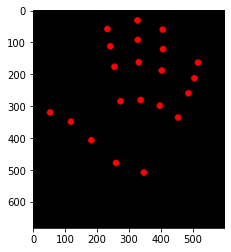

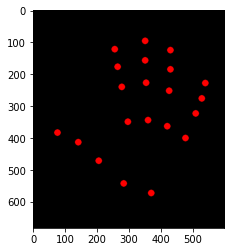

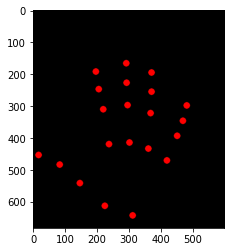

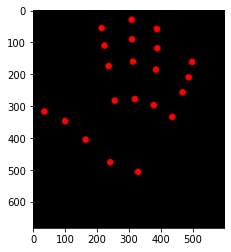

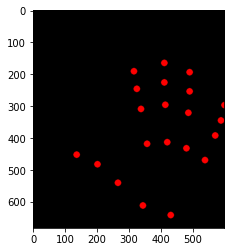

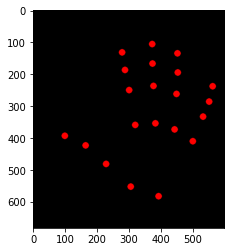

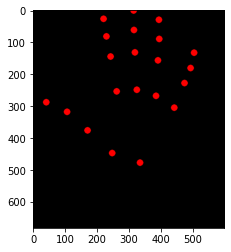

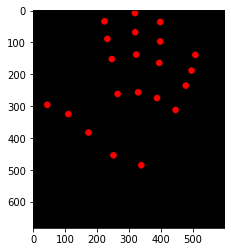

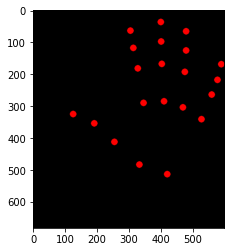

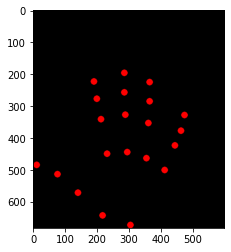

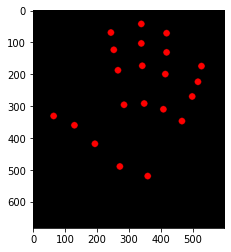

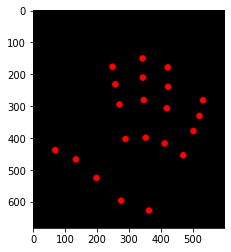

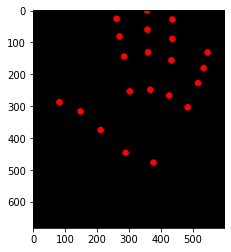

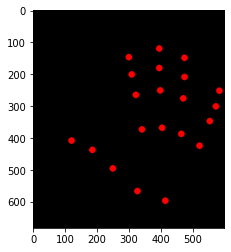

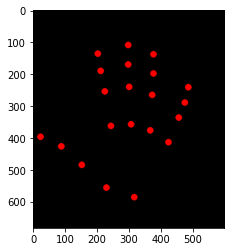

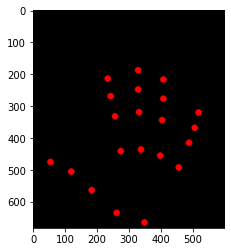

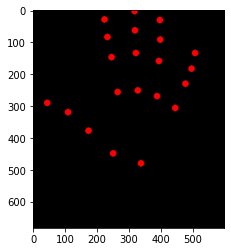

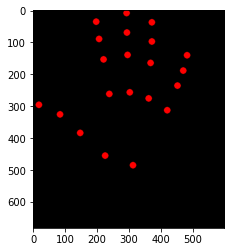

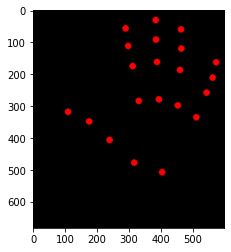

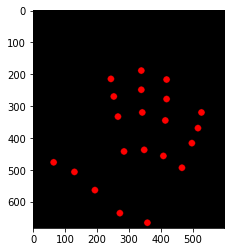

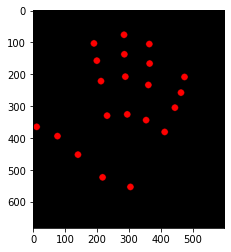

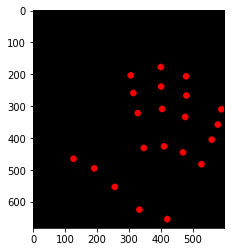

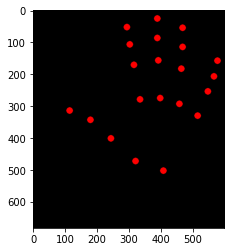

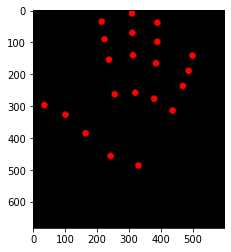

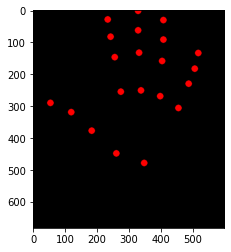

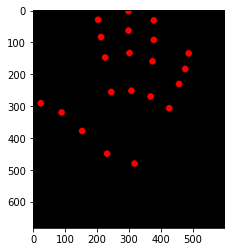

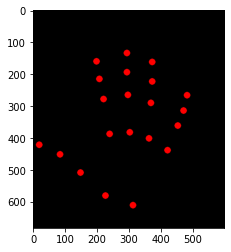

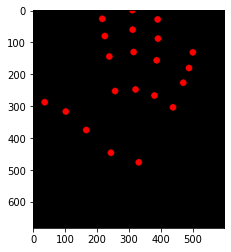

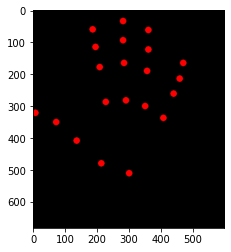

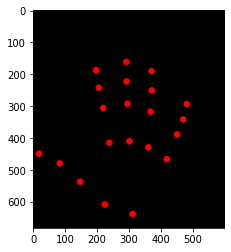

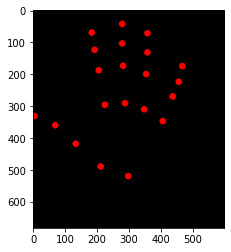

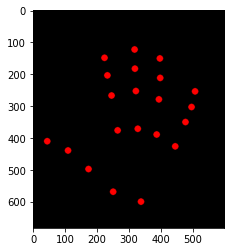

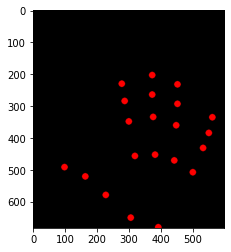

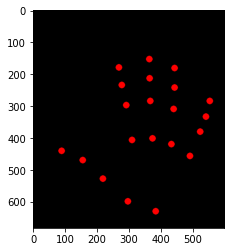

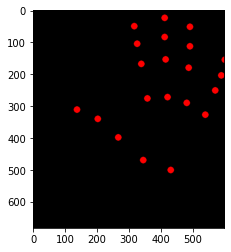

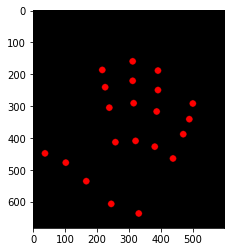

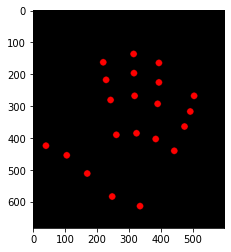

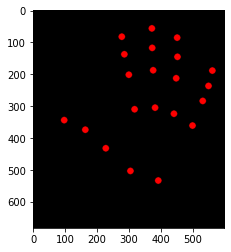

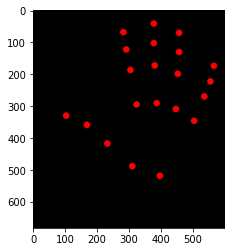

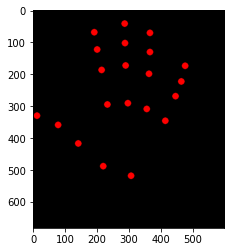

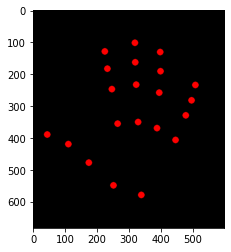

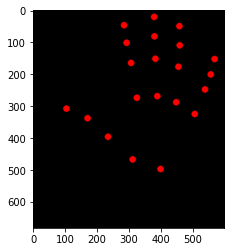

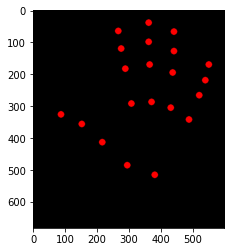

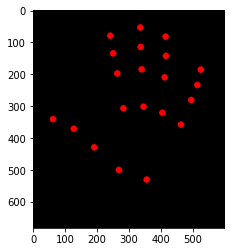

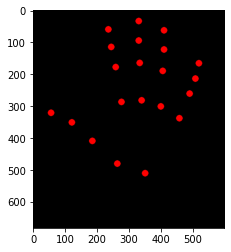

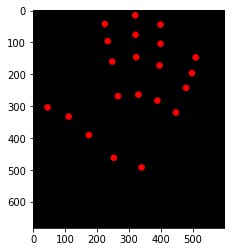

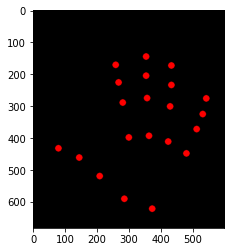

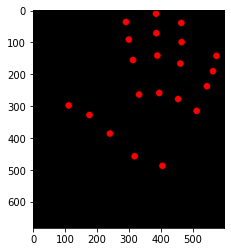

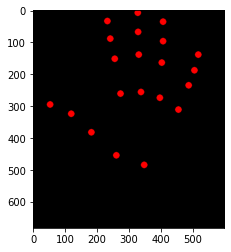

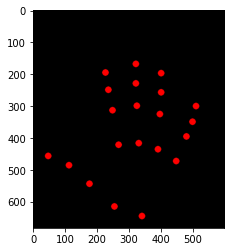

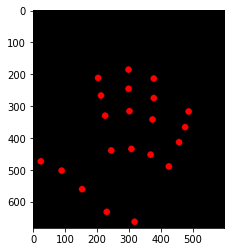

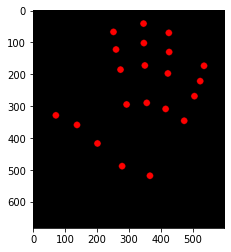

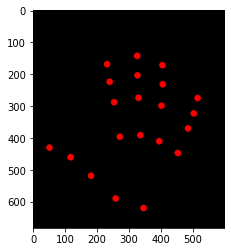

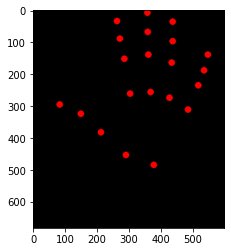

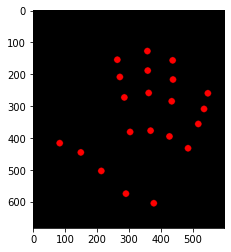

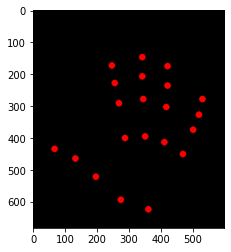

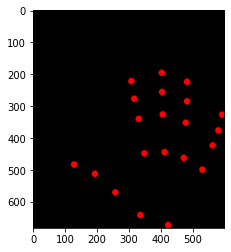

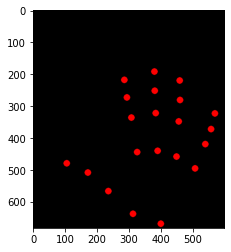

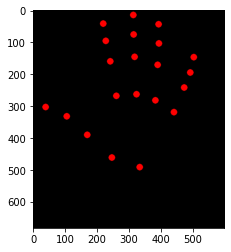

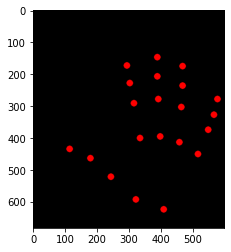

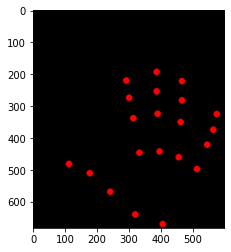

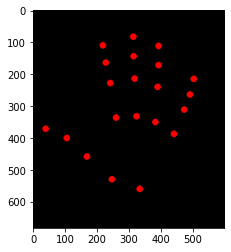

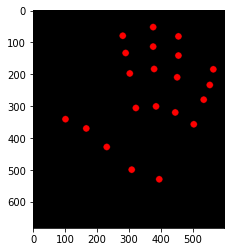

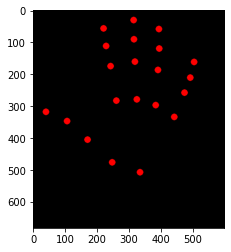

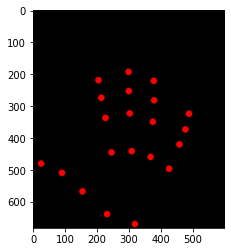

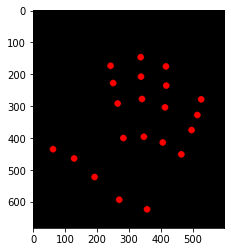

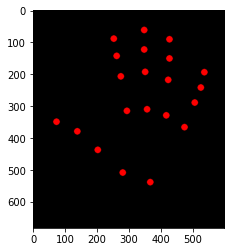

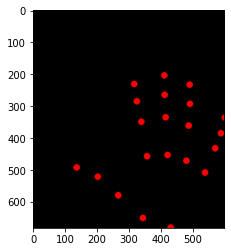

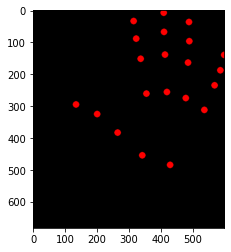

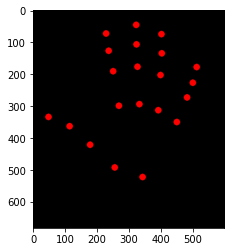

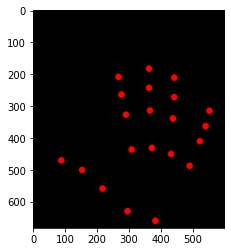

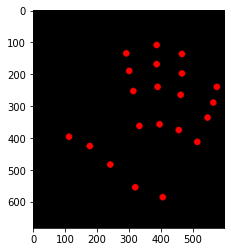

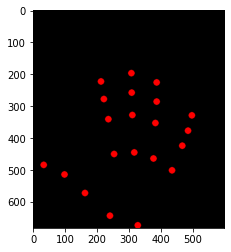

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2820, in while_loop
    return result  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2768, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 499, in compute
    return (i + 1, tas)  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 497, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "

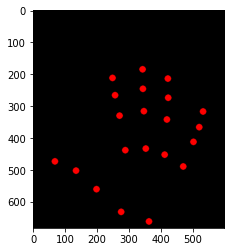

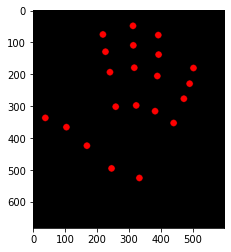

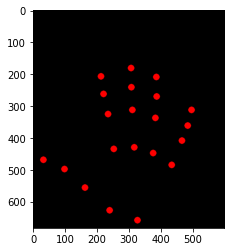

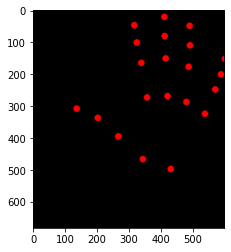

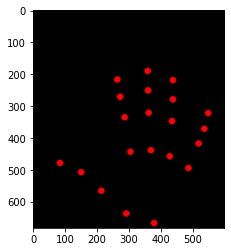

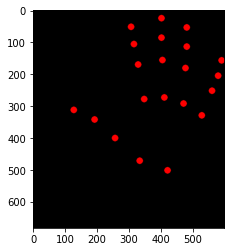

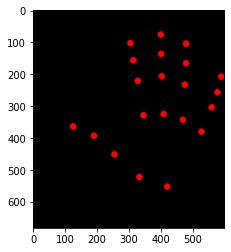

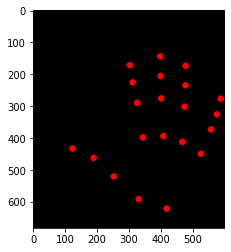

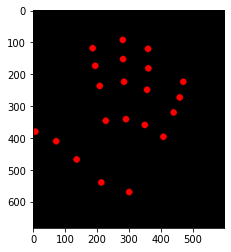

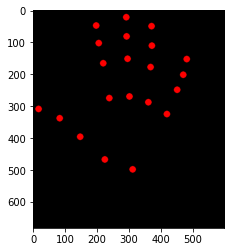

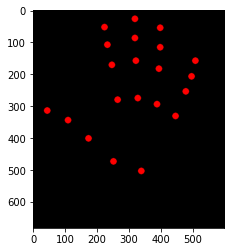

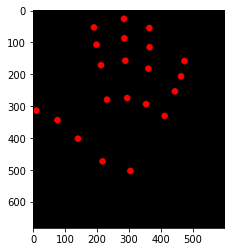

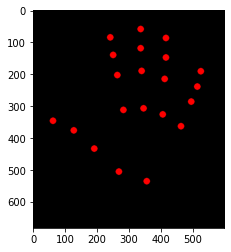

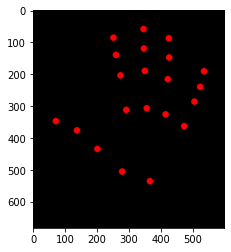

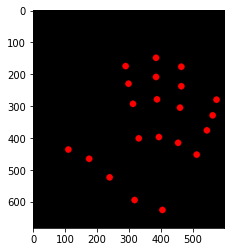

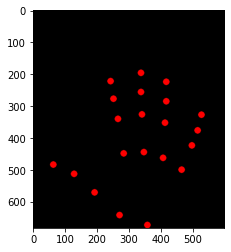

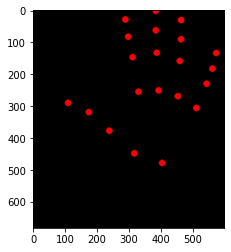

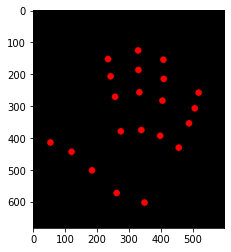

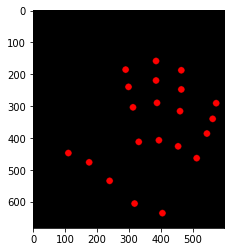

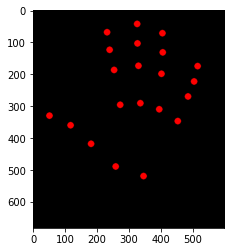

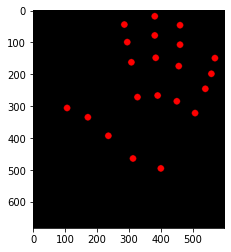

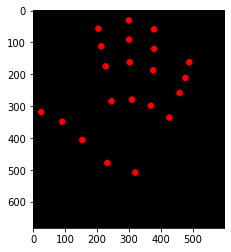

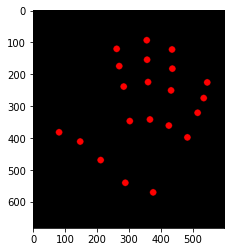

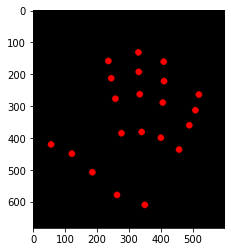

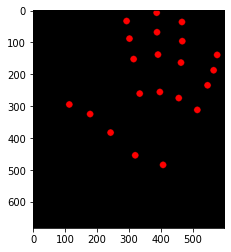

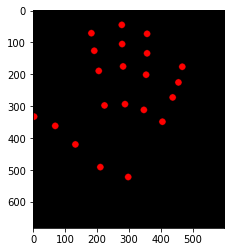

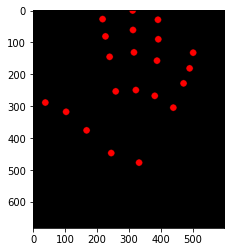

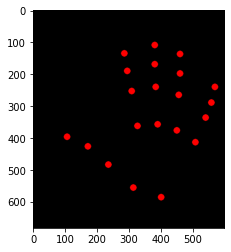

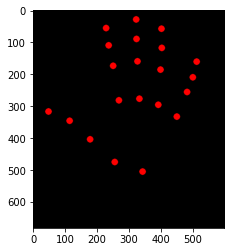

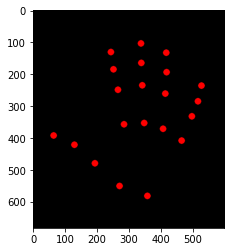

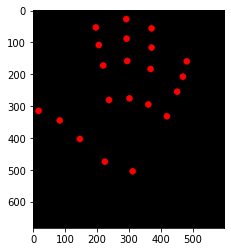

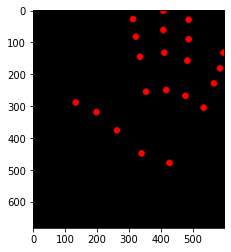

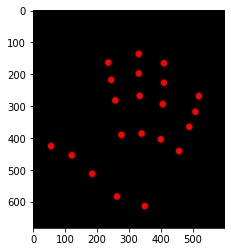

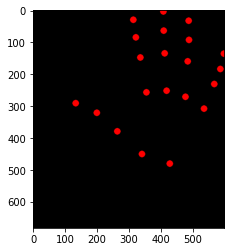

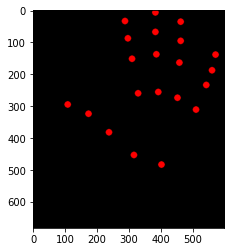

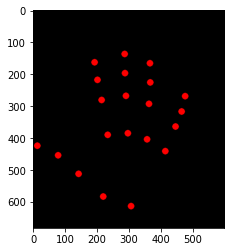

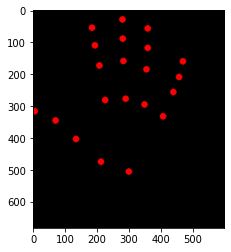

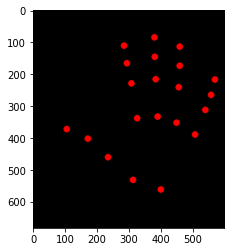

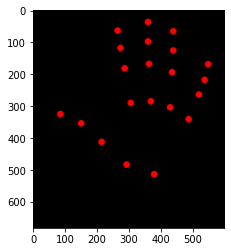

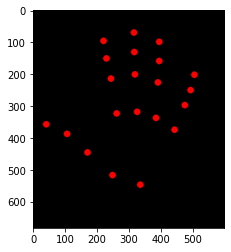

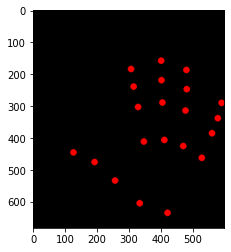

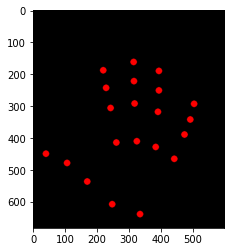

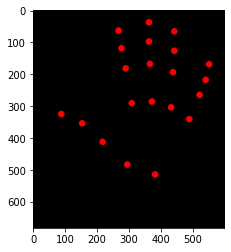

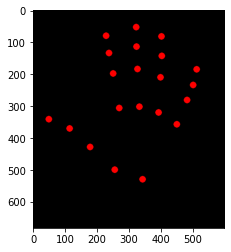

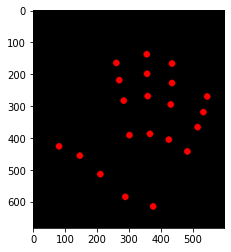

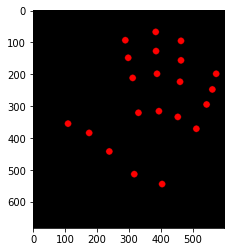

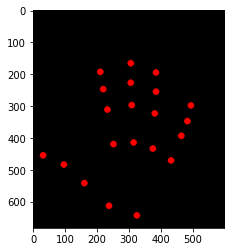

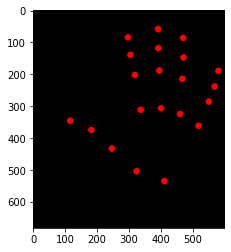

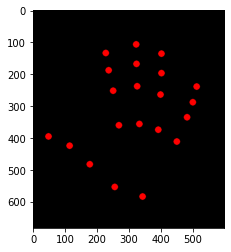

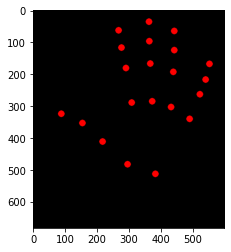

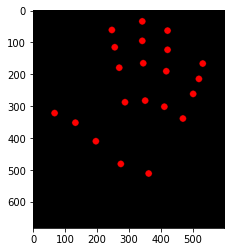

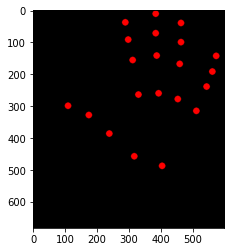

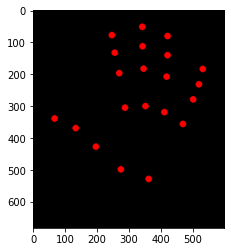

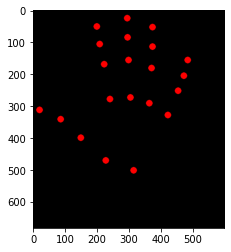

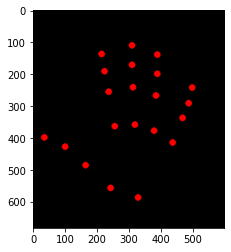

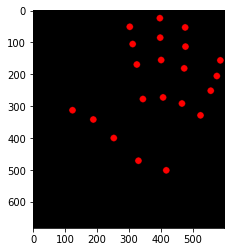

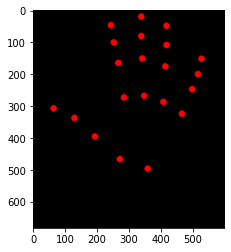

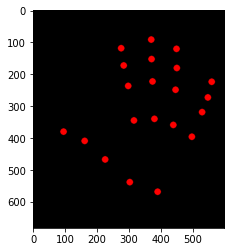

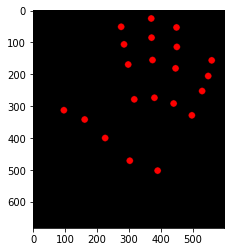

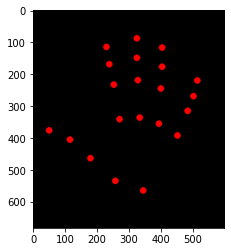

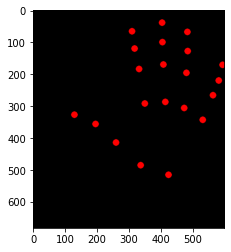

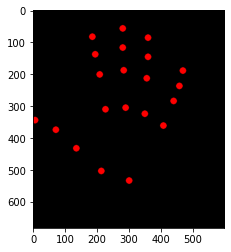

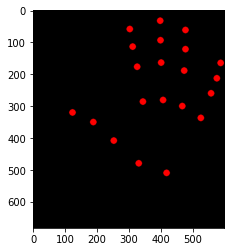

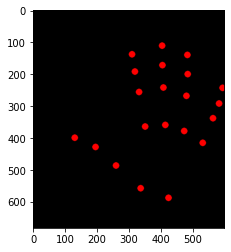

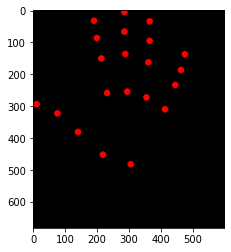

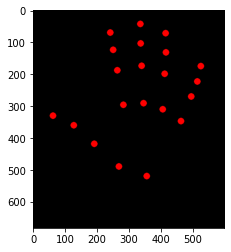

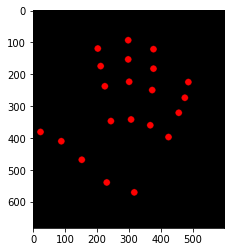

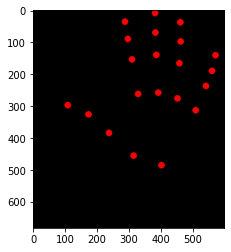

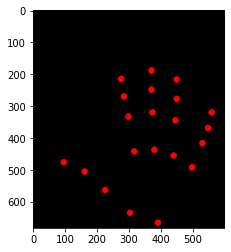

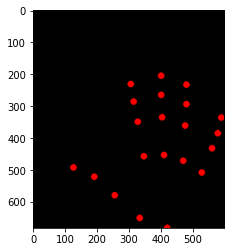

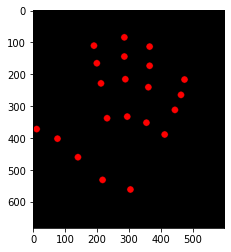

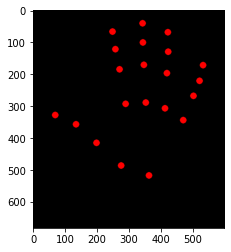

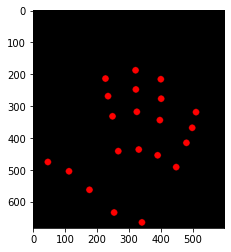

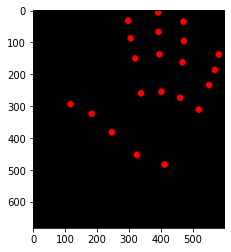

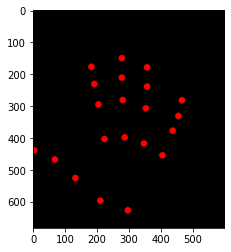

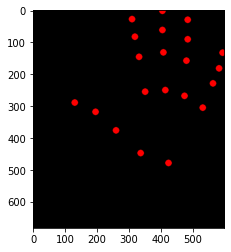

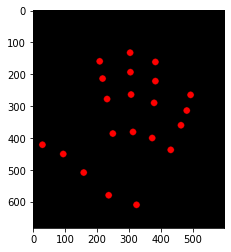

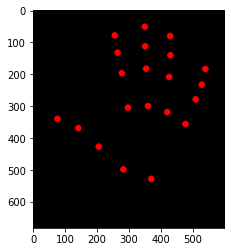

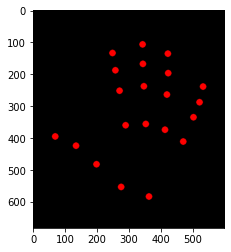

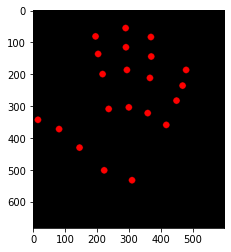

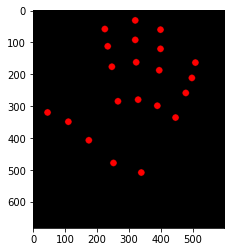

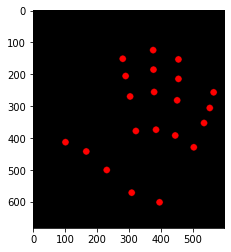

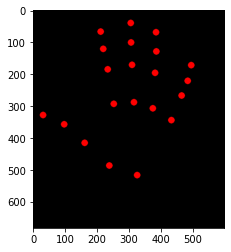

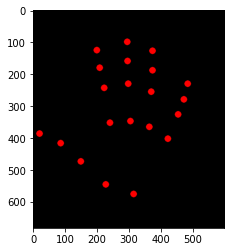

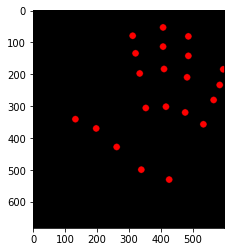

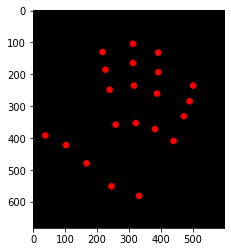

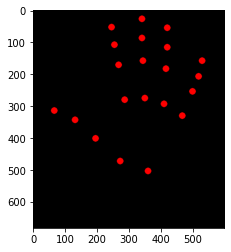

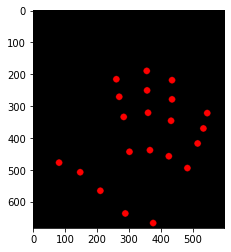

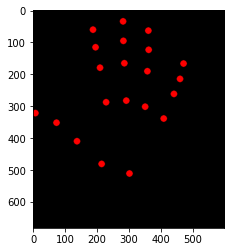

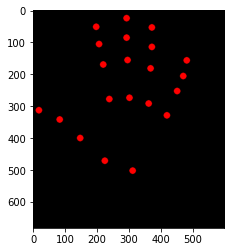

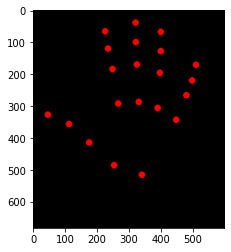

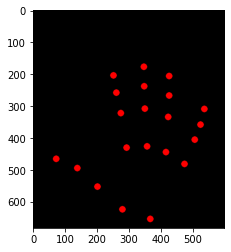

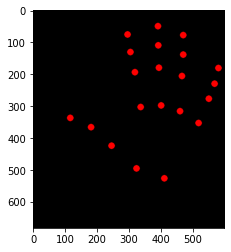

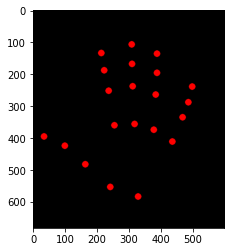

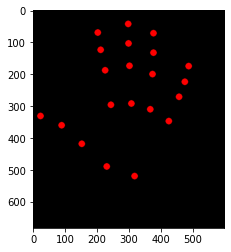

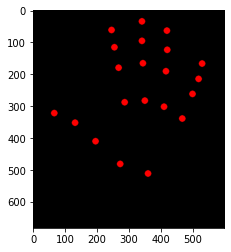

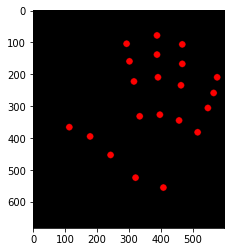

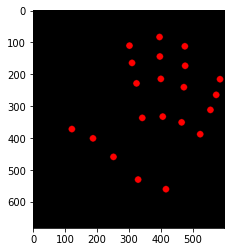

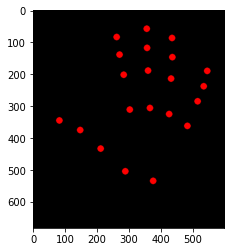

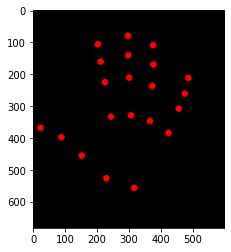

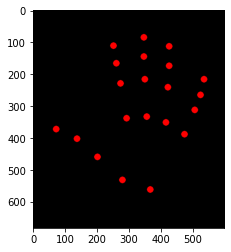

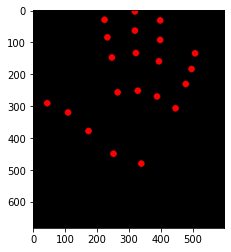

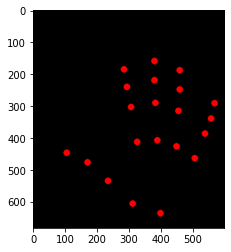

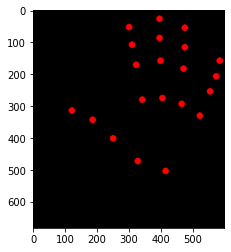

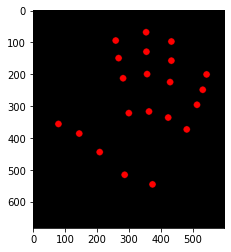

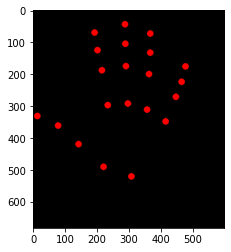

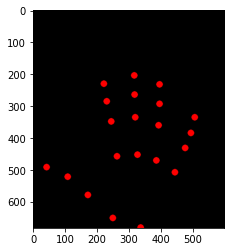

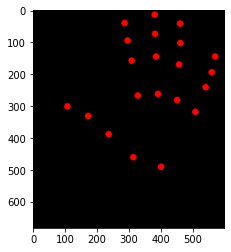

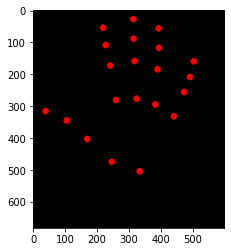

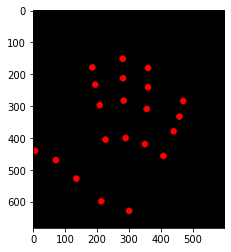

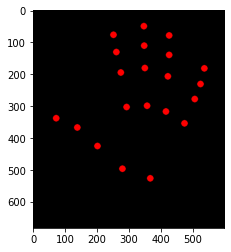

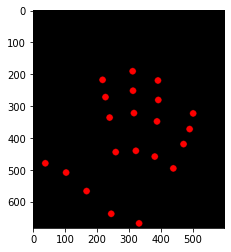

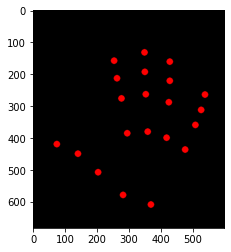

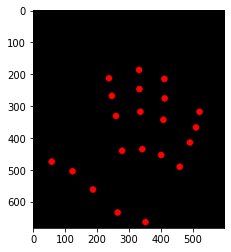

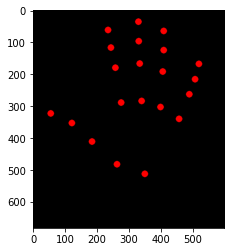

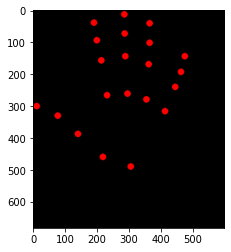

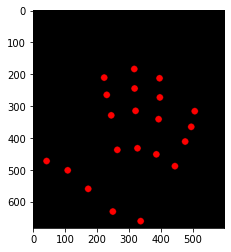

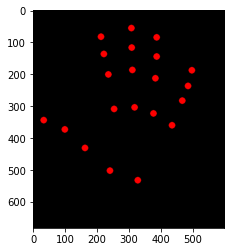

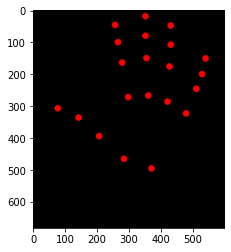

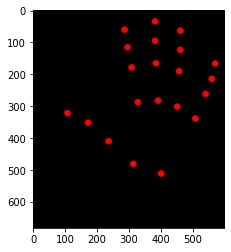

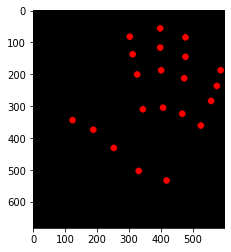

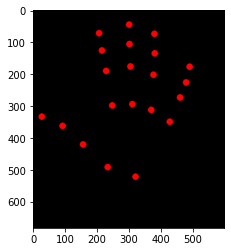

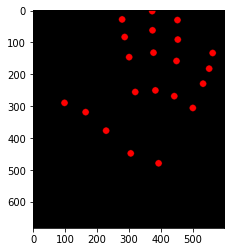

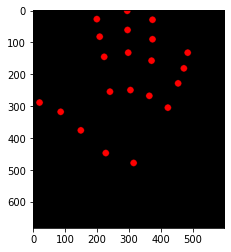

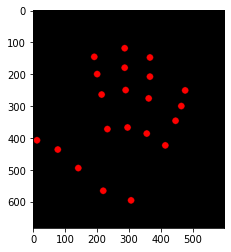

In [78]:
augger = Augmenter() 
new_locs = np.array([locations for _ in range(100)])
new_locs_aug = augger(np.array([new_locs]))[0]
new_locs_aug = np.array(new_locs_aug)

for _ in range(200): 
    new_locs_aug = _shift(new_locs)
    for locations_aug in np.array(new_locs_aug): 
        draw_on_image(image, locations_aug)
        break 

In [88]:
# training finally with an augmenter
model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(64, return_sequences = True), 
    tf.keras.layers.LSTM(128, return_sequences = True), 
    tf.keras.layers.LSTM(256, return_sequences = False), 
    tf.keras.layers.Dense(128, activation = "relu"), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

In [89]:
history = model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/200
3/3 [==============================] - 3s 770ms/step - loss: 0.7064 - accuracy: 0.3913 - val_loss: 0.5579 - val_accuracy: 0.6957
Epoch 2/200
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2820, in while_loop
    return result  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2768, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 499, in compute
    return (i + 1, tas)  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/s

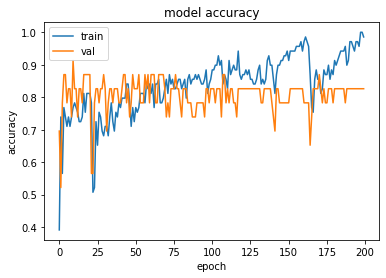

In [92]:
plot(history)

In [ ]:
X_train_aug = _shift(X_train)

In [ ]:
X_train_aug

one video has 30. fps
another one has 25fps 

take first X seconds (2 - 3.5 seconds)

predetermine seconds between each frame (0.1 seconds)

100 seconds, 30 fp/s 

90 frames, 30 fp/ half second

0th 
15th 
30th 
45th 
60th 
75th 
90th 

- make sure that the time in the video itself is also standardized 
- make sure that the time between frames is standardized 


NEXT STEPS FOR AUGMENTATION: 
- zoom augmentation
- horizontal flip with coordinates over an axis? 
- rotation of points

NameError: name 'tf' is not defined